In [4]:
# IMPORTING LIBRARIES
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import folium
import cv2
from scipy import ndimage
import pandas as pd
import geopandas as gpd
import folium
import itertools

In [5]:
place='Nakagawa-ku,Nagoya,Japan'

Latitudes are min: 35.109901 and max: 35.167973
Longitudes are min: 136.797307 and max: 136.898682


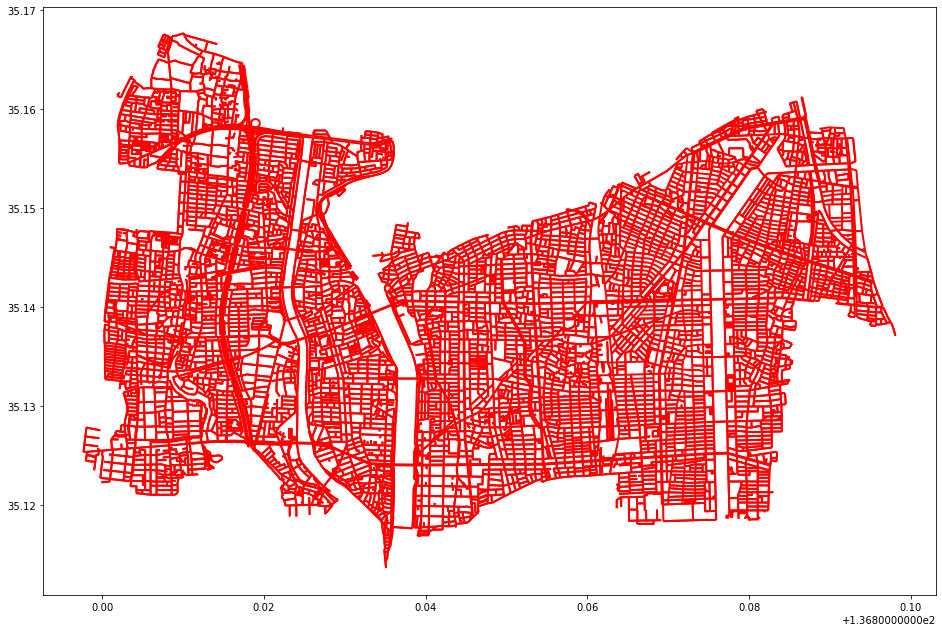

In [6]:
fig,ax=plt.subplots(figsize=(16,18))
G=ox.graph_from_place(place)
nodes,edges=ox.graph_to_gdfs(G)
edges.plot(ax=ax,linewidth=2,edgecolor='r')
nakagawa_area=ox.geocode_to_gdf(place)
nakagawa_buidlings=ox.geometries_from_place(place,{'building':True})

# get the lat and lon value from nakagawa area
lon_min, lon_max = nakagawa_area[['bbox_west']].values[0][0], nakagawa_area[['bbox_east']].values[0][0]
lat_max, lat_min = nakagawa_area[['bbox_north']].values[0][0], nakagawa_area[['bbox_south']].values[0][0]

print('Latitudes are min: {} and max: {}'.format(lat_min,lat_max))
print('Longitudes are min: {} and max: {}'.format(lon_min,lon_max))

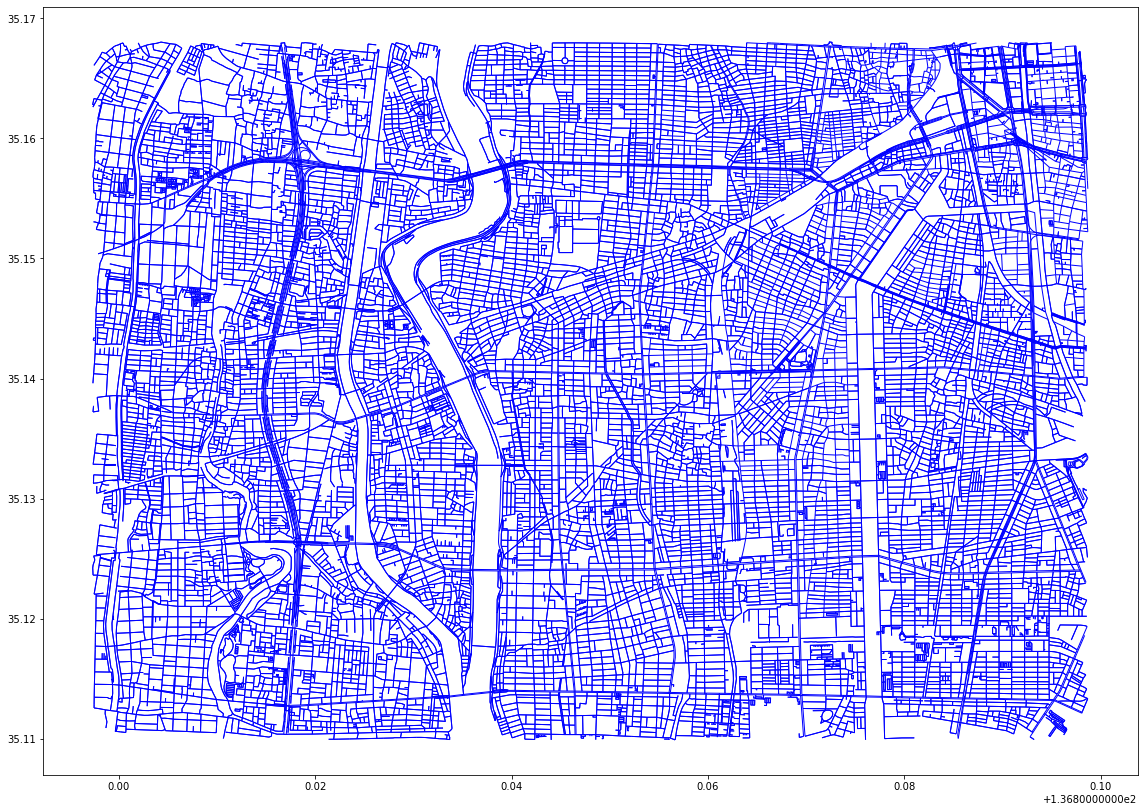

In [7]:
# construct box for distance transformation  as irregular shape does not give correct distances.
fig, ax = plt.subplots(figsize=(16,18))
G_nakagawa = ox.graph_from_bbox(lat_min,lat_max,lon_max,lon_min)
nodes_box,edges_box = ox.graph_to_gdfs(G_nakagawa)
northridge_box_gdf = ox.geocode_to_gdf(place)
edges_box.plot(ax=ax, linewidth=1, edgecolor='b')
plt.tight_layout()

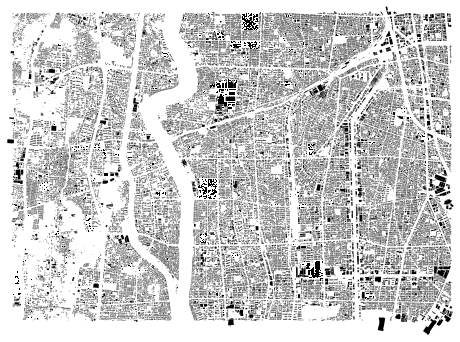

<AxesSubplot:>

In [10]:
nakagawa_building_bbox = ox.geometries_from_bbox(lat_min,lat_max,lon_max,lon_min, {'building':True})

fig, ax = ox.plot_footprints(nakagawa_building_bbox, figsize=(8, 8),color='black',bgcolor='#FFFFFF',save =True, filepath ='data/nakagawa_building.png',dpi=100)
ax.set_axis_off()
fig.add_axes(ax)

In [12]:
# Image Thresholding
import numpy as np
from PIL import Image
from skimage.filters.thresholding import threshold_otsu

In [16]:
nakagawa_building=Image.open('data/nakagawa_building.png').convert('L') # Convert to gray scale
nakagawa_building=np.asarray(nakagawa_building)
print('Max value of pixel in an image is',np.max(nakagawa_building))
print('Min value of pixel in an image is',np.min(nakagawa_building))

Max value of pixel in an image is 255
Min value of pixel in an image is 0


In [17]:
thresh=threshold_otsu(nakagawa_building)
print(f'Otsu threshold {thresh}')
# Pixesl with greater than thresh are kept
nakagawa_building_otsu_threshold=255*(nakagawa_building>thresh)

Otsu threshold 180


Text(0.5, 1.0, 'Original')

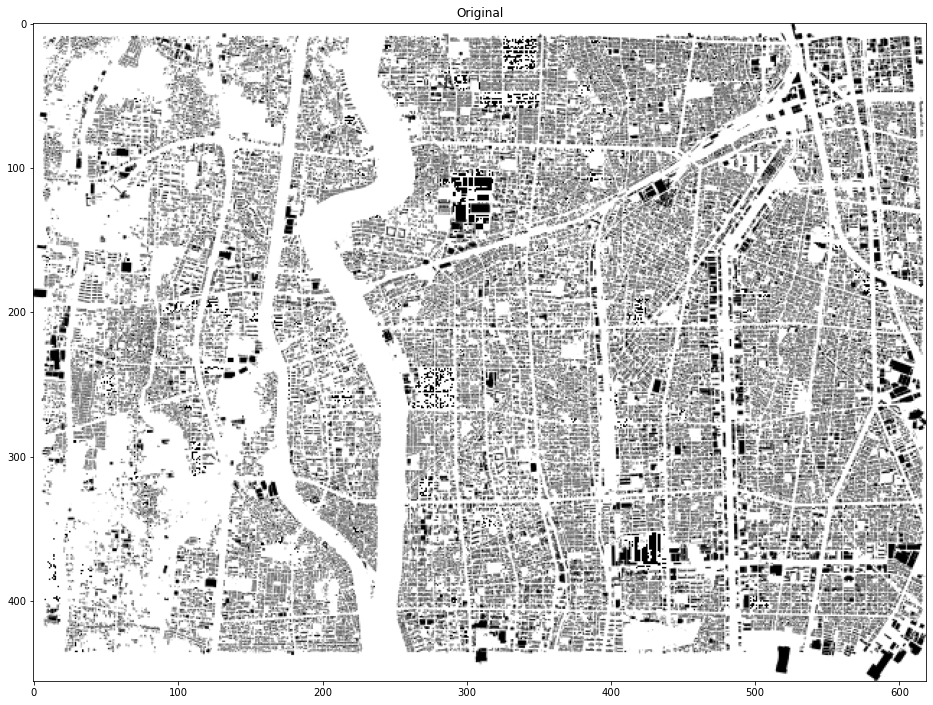

In [23]:
fig,ax=plt.subplots(figsize=(16,18))
plt.imshow(nakagawa_building,cmap='gray')
plt.title('Original')

Text(0.5, 1.0, ' Otsu Thresholding')

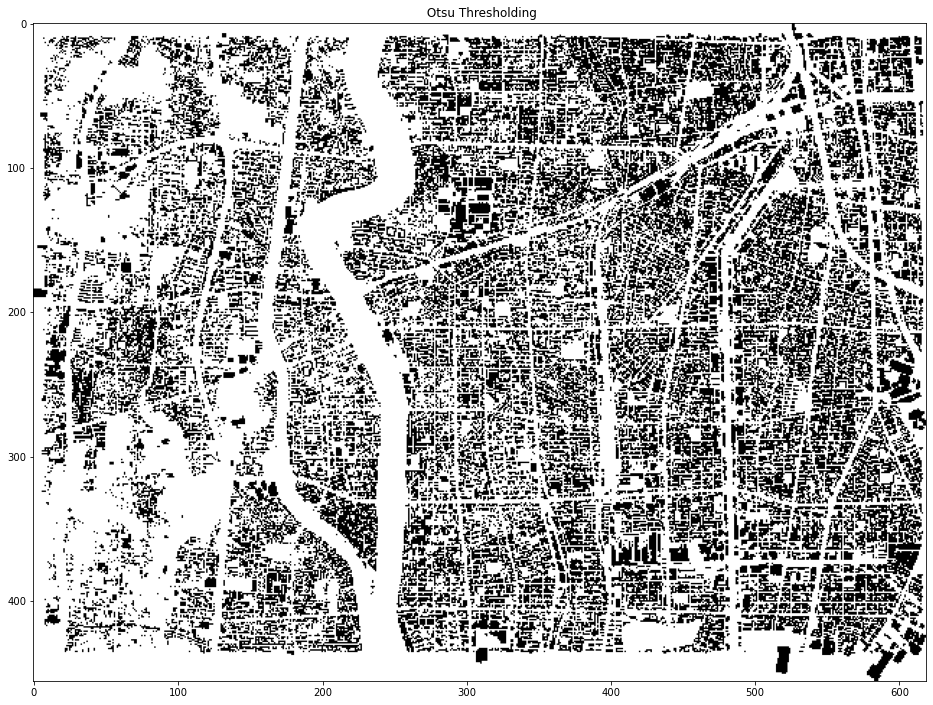

In [24]:
fig,ax=plt.subplots(figsize=(16,18))
plt.imshow(nakagawa_building_otsu_threshold,cmap='gray')
plt.title(' Otsu Thresholding')

In [26]:
nakagawa_building_adaptive_threshold=cv2.adaptiveThreshold(nakagawa_building,nakagawa_building.max(),\
                                                           cv2.ADAPTIVE_THRESH_MEAN_C,\
                                                           cv2.THRESH_BINARY,21,10)

Text(0.5, 1.0, 'Adaptive Thresholding')

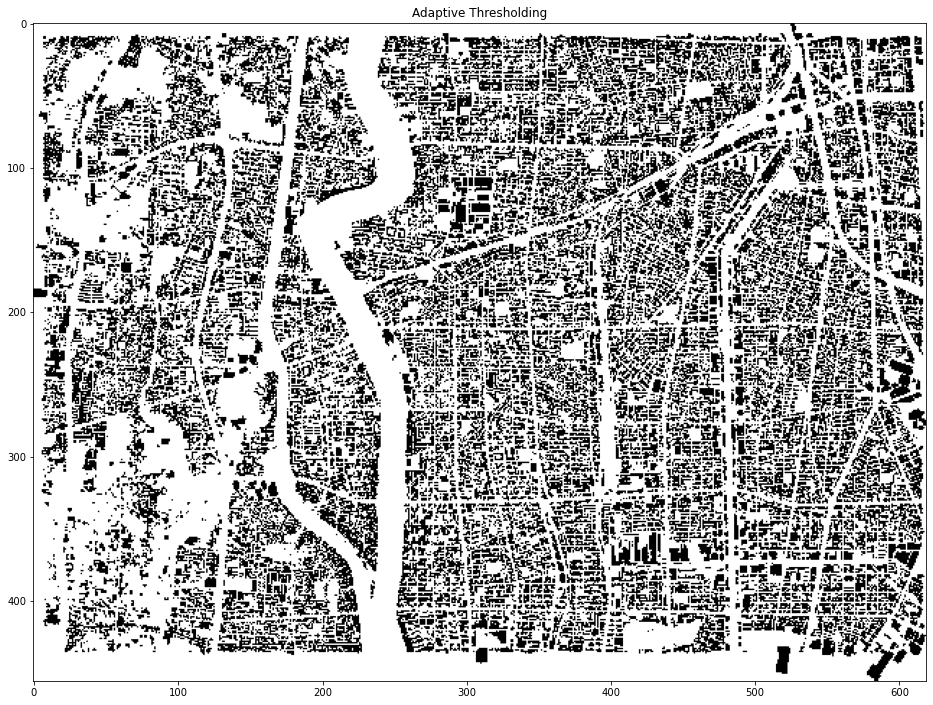

In [27]:
fig,ax=plt.subplots(figsize=(16,18))
plt.imshow(nakagawa_building_adaptive_threshold,cmap='gray')
plt.title('Adaptive Thresholding')

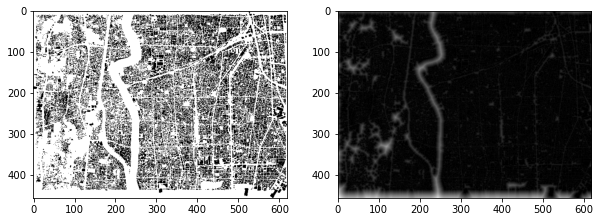

(456, 619)


In [28]:
# apply distance transformation
distance = ndimage.distance_transform_edt(nakagawa_building_otsu_threshold)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(nakagawa_building_otsu_threshold,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(distance,cmap = 'gray')
plt.show()

print(distance.shape)
distance = np.round(distance)

# save distance transform into numpy array
np.save('data/nakagawa_building_distance_transform.npy',distance,allow_pickle=True)

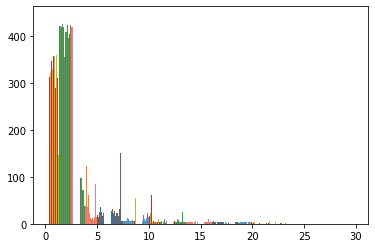

In [29]:
plt.hist(distance)
plt.show()

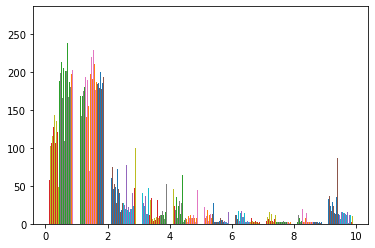

In [31]:
# Few extreme values will make the wider roads more risky ( extreme values come from the border of the graph)
# adjust to anything >= 10 to 10
distance = np.where(distance > 10,10, distance)
plt.hist(distance)
plt.show()

In [32]:
# merge the distance transform and the osmnx graph
summary = pd.DataFrame({'Name': ['x','y'],'max': [lon_max, lat_max],'min': [lon_min, lat_min]}).set_index('Name')
summary['np_matrix pixels'] = [distance.shape[1], distance.shape[0]] 
display(summary)

# generate latitude and longitude evenly spaced
lat_index = np.flip(np.linspace(summary['min'].y,summary['max'].y,summary['np_matrix pixels'].y))
lon_index = np.linspace(summary['min'].x,summary['max'].x,summary['np_matrix pixels'].x) 

max         min  np_matrix pixels
Name                                          
x     136.898682  136.797307               619
y      35.167973   35.109901               456

In [39]:
def list_lonlat(geom,summary,lon_index,lat_index):
    delta_x=geom.bounds[2]-geom.bounds[0]
    delta_y=geom.bounds[3]-geom.bounds[1]
    
    step_num=int(np.ceil(max(delta_x/abs(lon_index[1]-lon_index[0]),delta_y/abs(lat_index[1]-lat_index[0]))))
    coords_list=[geom.interpolate(i,normalized=True).coords[0] for i in np.linspace(0,step_num)]
    return coords_list

def lonlat_xy(list_,summary,lon_index,lat_index,array,filter_size=1):
    list_x=[i[0] for i in list_]
    list_y=[i[1] for i in list_]
    
    lon_min = lon_index.min()  
    list_x = [x if x >= lon_min else lon_min for x in list_x ]
    lon_max = lon_index.max()
    list_x = [x if x <= lon_max else lon_max for x in list_x ]
  
    lat_min = lat_index.min() 
    list_y = [y if y >= lat_min else lat_min for y in list_y ]
    lat_max = lat_index.max()
    list_y = [y if y <= lat_max else lat_max for y in list_y ]


    x = [np.nonzero((lon>=lon_index))[0][-1] for lon in list_x] 
    y = [np.nonzero((lat>=lat_index))[0][0] for lat in list_y]

    point_distance = []
    for i,v in zip(x,y):
        temp=[]
        for j in itertools.product(range(i-1,i+2),range(v-1,v+2)):
              if (j[1]<array.shape[0])&(j[0]<array.shape[1]) and j[0] >=0 and j[1] >=0:
                temp.append(array[j[1],j[0]])

        point_distance.append(max(temp))
    x_y = [[i,v] for i,v in zip(x,y)]
  # print("x_y",x_y)
    lon_lat = [[i,v] for i,v in zip(list_x,list_y)]
  # print("lon_lat",lon_lat)
    return point_distance, x_y, lon_lat

In [42]:
import statistics
def extract_value_from_matrix(geom, summary, lat_index, lon_index, array, filter_size = 1):
  #print("geom",geom)
  list_ = list_lonlat(geom, summary, lon_index, lat_index)
  #print("list",list_)
  assert len(list_) > 0
  array, x_y, lon_lat = lonlat_xy(list_, summary, lon_index, lat_index,array, filter_size)
  return {'sampling_counts': len(array),
          'max': max(array),
          'min': min(array),
          'mean': sum(array)/len(array),
          'median': statistics.median(array),
          'x_y': x_y,
          'lon_lat': lon_lat}

In [43]:
# get information for every edge in the graph
_ = edges.geometry.apply(lambda x: extract_value_from_matrix(x, summary, lat_index, lon_index, distance, filter_size = 1))

# merge the additional information with the existing edges dataframe
edges_extended = edges.merge(pd.DataFrame({ 'sampling_counts' : _.apply(lambda x: x['sampling_counts']),
                                          'max': _.apply(lambda x: x['max']),
                                          'min': _.apply(lambda x: x['min']),
                                          'mean': _.apply(lambda x: x['mean']),
                                          'median': _.apply(lambda x: x['median']),
                                          'x_y': _.apply(lambda x: x['x_y']),
                                          'lon_lat': _.apply(lambda x: x['lon_lat'])}), left_index=True, right_index=True)

In [44]:
edges_extended.head()

osmid  \
u         v          key                                                 
287037206 6418759114 0                          [235402848, 940877736]   
          8687399278 0    [937718833, 940585691, 766866772, 766866773]   
287051498 1161617447 0                                       140501318   
          3909362365 0                                       311076737   
287051557 7561108865 0                                       808602349   

                                  bridge  oneway lanes       ref  \
u         v          key                                           
287037206 6418759114 0    [viaduct, yes]    True     2  [5, E23]   
          8687399278 0               yes    True   NaN       NaN   
287051498 1161617447 0               NaN   False   NaN       NaN   
          3909362365 0               NaN    True     2         1   
287051557 7561108865 0               NaN   False     2       106   

                                           name        highway   length  \
u         v          key                                                  
287037206 6418759114 0    [名古屋高速5号万場線, 東名阪自動車道]       motorway  549.217   
          8687399278 0              名古屋第二環状自動車道  motorway_link  717.481   
287051498 1161617447 0                      NaN   unclassified   12.298   
          3909362365 0                     国道1号          trunk  106.927   
287051557 7561108865 0                  鳥ヶ地名古屋線      secondary   12.813   

                                                                   geometry  \
u         v          key                                                      
287037206 6418759114 0    LINESTRING (136.81737 35.15822, 136.81780 35.1...   
          8687399278 0    LINESTRING (136.81737 35.15822, 136.81817 35.1...   
287051498 1161617447 0    LINESTRING (136.84672 35.12402, 136.84672 35.1...   
          3909362365 0    LINESTRING (136.84672 35.12402, 136.84555 35.1...   
287051557 7561108865 0    LINESTRING (136.83310 35.12414, 136.83311 35.1...   

                         est_width  ... tunnel service width sampling_counts  \
u         v          key            ...                                        
287037206 6418759114 0         NaN  ...    NaN     NaN   NaN              50   
          8687399278 0         NaN  ...    NaN     NaN   NaN              50   
287051498 1161617447 0         NaN  ...    NaN     NaN   NaN              50   
          3909362365 0         NaN  ...    NaN     NaN   NaN              50   
287051557 7561108865 0         NaN  ...    NaN     NaN   NaN              50   

                          max  min  mean  median  \
u         v          key                           
287037206 6418759114 0    2.0  1.0  1.02     1.0   
          8687399278 0    4.0  1.0  1.08     1.0   
287051498 1161617447 0    1.0  1.0  1.00     1.0   
          3909362365 0    2.0  1.0  1.06     1.0   
287051557 7561108865 0    1.0  1.0  1.00     1.0   

                                                                        x_y  \
u         v          key                                                      
287037206 6418759114 0    [[122, 77], [149, 81], [158, 82], [158, 82], [...   
          8687399278 0    [[122, 77], [128, 75], [131, 98], [131, 98], [...   
287051498 1161617447 0    [[301, 345], [301, 345], [301, 345], [301, 345...   
          3909362365 0    [[301, 345], [300, 345], [298, 345], [297, 345...   
287051557 7561108865 0    [[218, 344], [218, 344], [218, 344], [218, 344...   

                                                                    lon_lat  
u         v          key                                                     
287037206 6418759114 0    [[136.8173714, 35.1582232], [136.8218790974379...  
          8687399278 0    [[136.8173714, 35.1582232], [136.8184199204124...  
287051498 1161617447 0    [[136.8467234, 35.1240208], [136.8467233959183...  
          3909362365 0    [[136.8467234, 35.1240208], [136.8465314489796...  
287051557 7561108865 0    [[136.8330982, 

In [45]:
edges_extended.columns.tolist()

['osmid',
 'bridge',
 'oneway',
 'lanes',
 'ref',
 'name',
 'highway',
 'length',
 'geometry',
 'est_width',
 'maxspeed',
 'tunnel',
 'service',
 'width',
 'sampling_counts',
 'max',
 'min',
 'mean',
 'median',
 'x_y',
 'lon_lat']

In [46]:
# calculate mean and median distance for each edge and choose the one which is the minimum value
edges_extended['mean_scaled'] = edges_extended['mean'].apply(lambda x: np.exp(np.interp(x, (edges_extended['mean'].min(), edges_extended['mean'].max()), (0, 5))))
edges_extended['median_scaled'] = edges_extended['median'].apply(lambda x: np.exp(np.interp(x, (edges_extended['median'].min(), edges_extended['median'].max()), (0, 5))))
edges_extended['mean_scaled_inversed'] = edges_extended['mean_scaled'].apply(lambda x: abs(x - edges_extended['mean_scaled'].max()))
edges_extended['median_scaled_inversed'] = edges_extended['median_scaled'].apply(lambda x: abs(x - edges_extended['median_scaled'].max()))
#edges_extended['distance_risk_score'] = edges_extended[['mean_scaled_inversed','median_scaled_inversed']].apply(lambda x: min(x[0],x[1]),axis=1)
edges_extended['distance_risk_score'] = edges_extended['max'].apply(lambda x: abs(x - edges_extended['max'].max()))
# add color to the edge based on risk_score
print(edges_extended.distance_risk_score.unique())

[ 8.  6.  9.  7.  5.  0.  3.  1. 10.  4.  2.]


In [47]:
def color_func(x):
    if x <= 3:
        col = 'blue'
    elif x <= 6:
        col = 'yellow'
    else:
        col = 'red'
    return col 

edges_extended['edge_color'] = edges_extended['distance_risk_score'].apply(lambda x: color_func(x))
edges_extended.head()

osmid  \
u         v          key                                                 
287037206 6418759114 0                          [235402848, 940877736]   
          8687399278 0    [937718833, 940585691, 766866772, 766866773]   
287051498 1161617447 0                                       140501318   
          3909362365 0                                       311076737   
287051557 7561108865 0                                       808602349   

                                  bridge  oneway lanes       ref  \
u         v          key                                           
287037206 6418759114 0    [viaduct, yes]    True     2  [5, E23]   
          8687399278 0               yes    True   NaN       NaN   
287051498 1161617447 0               NaN   False   NaN       NaN   
          3909362365 0               NaN    True     2         1   
287051557 7561108865 0               NaN   False     2       106   

                                           name        highway   length  \
u         v          key                                                  
287037206 6418759114 0    [名古屋高速5号万場線, 東名阪自動車道]       motorway  549.217   
          8687399278 0              名古屋第二環状自動車道  motorway_link  717.481   
287051498 1161617447 0                      NaN   unclassified   12.298   
          3909362365 0                     国道1号          trunk  106.927   
287051557 7561108865 0                  鳥ヶ地名古屋線      secondary   12.813   

                                                                   geometry  \
u         v          key                                                      
287037206 6418759114 0    LINESTRING (136.81737 35.15822, 136.81780 35.1...   
          8687399278 0    LINESTRING (136.81737 35.15822, 136.81817 35.1...   
287051498 1161617447 0    LINESTRING (136.84672 35.12402, 136.84672 35.1...   
          3909362365 0    LINESTRING (136.84672 35.12402, 136.84555 35.1...   
287051557 7561108865 0    LINESTRING (136.83310 35.12414, 136.83311 35.1...   

                         est_width  ...  mean median  \
u         v          key            ...                
287037206 6418759114 0         NaN  ...  1.02    1.0   
          8687399278 0         NaN  ...  1.08    1.0   
287051498 1161617447 0         NaN  ...  1.00    1.0   
          3909362365 0         NaN  ...  1.06    1.0   
287051557 7561108865 0         NaN  ...  1.00    1.0   

                                                                        x_y  \
u         v          key                                                      
287037206 6418759114 0    [[122, 77], [149, 81], [158, 82], [158, 82], [...   
          8687399278 0    [[122, 77], [128, 75], [131, 98], [131, 98], [...   
287051498 1161617447 0    [[301, 345], [301, 345], [301, 345], [301, 345...   
          3909362365 0    [[301, 345], [300, 345], [298, 345], [297, 345...   
287051557 7561108865 0    [[218, 344], [218, 344], [218, 344], [218, 344...   

                                                                    lon_lat  \
u         v          key                                                      
287037206 6418759114 0    [[136.8173714, 35.1582232], [136.8218790974379...   
          8687399278 0    [[136.8173714, 35.1582232], [136.8184199204124...   
287051498 1161617447 0    [[136.8467234, 35.1240208], [136.8467233959183...   
          3909362365 0    [[136.8467234, 35.1240208], [136.8465314489796...   
287051557 7561108865 0    [[136.8330982, 35.1241415], [136.8330984469387...   

                          mean_scaled  median_scaled  mean_scaled_inversed  \
u         v          key                                                     
287037206 6418759114 0       1.665291       1.648721            146.747868   
          8687399278 0       1.716007       1.648721            146.697152   
287051498 1161617447 0       1.648721       1.648721            146.764438   
          3909362365 0       1.698932       1.648721            146.714227   
287051557 7561108865

In [48]:
 ox.settings.useful_tags_node

['ref', 'highway']

In [49]:
ox.settings.osm_xml_node_attrs

['id', 'timestamp', 'uid', 'user', 'version', 'changeset', 'lat', 'lon']

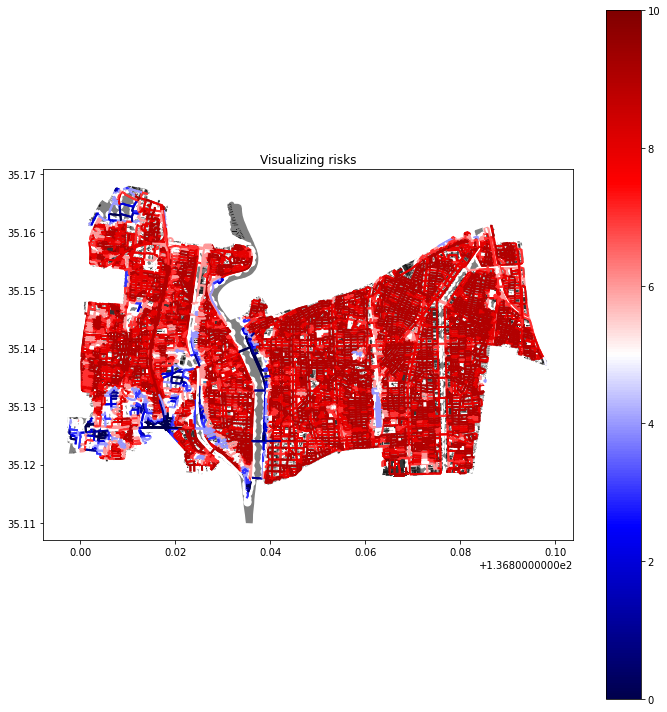

In [55]:
# convert the existing nodes and new edge information into a graph
import matplotlib
utn = ox.settings.useful_tags_node
oxna = ox.settings.osm_xml_node_attrs
oxnt = ox.settings.osm_xml_node_tags
utw = ox.settings.useful_tags_way
oxwa = ox.settings.osm_xml_way_attrs
oxwt = ox.settings.osm_xml_way_tags
utn = list(set(utn + oxna + oxnt))
utw = list(set(utw + oxwa + oxwt))
ox.config(all_oneway=True, useful_tags_node=utn, useful_tags_way=utw)
graph_with_Building_dist = ox.graph_from_gdfs(nodes, edges_extended)

# get the geodataframe information of the graph
new_nodes,new_edges = ox.graph_to_gdfs(graph_with_Building_dist)

fig, ax = plt.subplots(figsize=(10, 10))
# plot area
nakagawa_area.plot(ax=ax, facecolor='gray')
# plot edges and nodes
new_edges.plot(ax=ax, linewidth=2, column='distance_risk_score', cmap='seismic')
new_nodes.plot(ax=ax, linewidth=2, facecolor='white')
# plot buildings
nakagawa_buidlings.plot(ax=ax, facecolor='black', alpha=0.8)
sm = plt.cm.ScalarMappable(cmap='seismic', norm = matplotlib.colors.Normalize(vmin=new_edges['distance_risk_score'].min(), vmax=new_edges['distance_risk_score'].max()))
sm.set_array([])
fig.colorbar(sm, ax=ax)
ax.set_title('Visualizing risks')
fig.tight_layout()

In [53]:
# save the footprints, graph and gdf
nx.write_gpickle(nakagawa_buidlings,'/content/gdrive/My Drive/omdena/earthquake/chatsworth_footprint.pickle')
nx.write_gpickle(graph_with_Building_dist, '/content/gdrive/My Drive/omdena/earthquake/1_1_chatsworth_graph_distance_risk_added.pickle')
nx.write_gpickle(nakagawa_area,'/content/gdrive/My Drive/omdena/earthquake/chatsworth_gdf.pickle')

Object `plt.colors` not found.
